Now, let's demonstrate a more "real-life" example of **polynomial regression**.

For that sake, let's first explore some data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Load data

In [2]:
cars = pd.read_csv('data/mercedes_c220.csv')
cars.head()

,years,km,hp,transmission,price
0,18,185000,150,2,500
1,23,281397,143,1,750
2,29,300000,95,1,850
3,25,383873,125,2,950
4,20,373000,150,1,1112


In [3]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
years,1177.0,14.723874,5.543678,1.0,10.0,15.0,18.0,32.0
km,1177.0,226318.264231,68232.120371,6200.0,190000.0,224000.0,263285.0,473890.0
hp,1177.0,165.182668,17.739607,95.0,150.0,170.0,170.0,270.0
transmission,1177.0,1.738318,0.439737,1.0,1.0,2.0,2.0,2.0
price,1177.0,9729.793543,8715.158180,500.0,4400.0,6750.0,13425.0,62327.0


## 2. Scale features
First, we need to scale the features. For that sake we'll use a **Z-score** normalization.

$$x` = \frac{x - \mu}{\sigma}$$ 
where $\mu$ is the feature **mean** value and $\sigma$ is the feature **standard deviation**.

In [4]:
def z_score(x: pd.Series):
    return (x - x.mean()) / x.std()

# Normalize the scalar features
cars[['years', 'km', 'hp']] = cars[['years', 'km', 'hp']].apply(z_score)
# We can also apply a simple scaling on the price, by dividing it by 1000
cars['price'] = cars['price'] / 1000

# Show the results
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
years,1177.0,0.000000e+00,1.000000,-2.475590,-0.852119,0.049809,0.590966,3.116365
km,1177.0,2.414759e-16,1.000000,-3.226021,-0.532275,-0.033976,0.541779,3.628375
hp,1177.0,6.761324e-16,1.000000,-3.956270,-0.855863,0.271558,0.271558,5.908662
transmission,1177.0,1.738318e+00,0.439737,1.000000,1.000000,2.000000,2.000000,2.000000
price,1177.0,9.729794e+00,8.715158,0.500000,4.400000,6.750000,13.425000,62.327000


## 3. Data analysis
Now, let's explore the data and see what are the potential relationships between the input features and the output `price`.

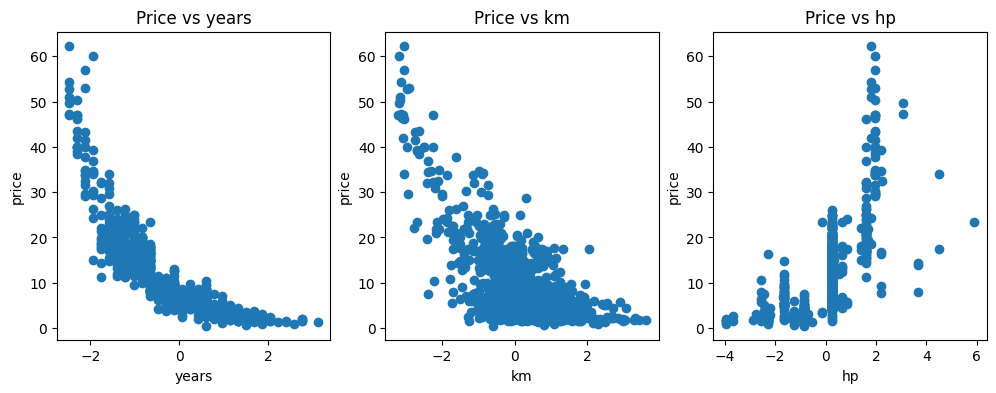

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(cars['years'], cars['price'])
plt.xlabel('years')
plt.ylabel('price')
plt.title('Price vs years')

plt.subplot(1, 3, 2)
plt.scatter(cars['km'], cars['price'])
plt.xlabel('km')
plt.ylabel('price')
plt.title('Price vs km')

plt.subplot(1, 3, 3)
plt.scatter(cars['hp'], cars['price'])
plt.xlabel('hp')
plt.ylabel('price')
plt.title('Price vs hp')

plt.show()

Observations:
* We observe an **inverse correlation** between `price` and `years` / `km`, which is not a surprise - the older the car, the cheaper it is.
* We observe a **direct correlation** between `price` and `hp`. Which is also expected - the more powerful a car is, the more expensive it is.

Please note, however, that none of the relations are **linear**. They look more like **quadratic** (**polynomial**).

## 4. Polynomial regression
So, we'll have to implement a polynomial regression from **second degree** for **three features**:
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3  + \beta_4 x_1 x_2 + \beta_5 x_1 x_2 + \beta_6 x_2 x_3 + \beta_7 x_1^2 + \beta_8 x_2^2 + \beta_9 x_3^2$$

### 4.1 3D into 10D vector
But firstly, we'll need a method to transform $x_1, x_2, x_3$ into a vector of all powered feature values.

$$ (x_1, x_2, x_3) => (1, x_1, x_2, x_3, x_1 x_2, x_1 x_3, x_2 x_3, x_1^2, x_2^2, x_3^2)$$

In [6]:
def transform_to_2nd_degree_polynomial(x: np.ndarray) -> np.ndarray:
    n = x.shape[0] # Number of features
    # STEP 1: We start with 1, because the polynomial always has 1 as the first term
    terms = [1]
    # STEP 2: Now we add all the first degree terms (x_i)
    for i in range(n):
        terms.append(x[i])
    # STEP 3: Now we add all the combinations of the first degree terms (x_i * x_j).
    for i in range(n):
        for j in range(i+1, n): # We start from i+1 to **avoid duplicates**
            terms.append(x[i] * x[j])
    # STEP 4: Now we add all the second degree terms (x_i^2)
    for i in range(n):
        terms.append(x[i]**2)
    return terms

### 4.2 3D into 10D dataset
Now, let's upgrade the transformation function to support not single observations, but a whole dataset.

In [7]:
def transform_to_2nd_degree_matrix(X: np.ndarray) -> np.ndarray:
    '''Transforms the input dataset into a set of 2nd degree polynomials.'''
    output_matrix = []
    for x in X:
        X_poly = transform_to_2nd_degree_polynomial(x)
        output_matrix.append(X_poly)
    return np.array(output_matrix)

### 4.3 Gradient descent
Now, let's implement the gradient descent.

In [8]:
def fit(X: np.ndarray, Y: np.ndarray, epochs: int, learn_rate: float):
    # Initialize the weights
    weights = np.random.randn(10)
    # Train the model
    for _ in range(epochs):
        # Transform the flat observations matrix to a polynomial matrix
        X_poly = transform_to_2nd_degree_matrix(X) # (m, 10)
        # Calculate the predicted values
        Y_pred = np.dot(X_poly, weights) # (m,10) @ (10,1) = (m, 1)
        # Calculate the error
        error = Y_pred - Y # (m, 1) - (m, 1) = (m, 1)
        # Update the weights
        weights -= learn_rate * (X_poly.T @ error) # (10,m) @ (m,1) = (10,1)
        # Once in a 100 iterations, print the latest loss
        if _ % 100 == 0:
            loss = np.sum(error**2)/X.shape[0]
            print(f"Iteration {_} - Loss: {loss}")

    return weights

## 5. Fit the model
Now let's fit the model to the data.

In [9]:
X = cars[['years', 'km', 'hp']].values
Y = cars['price'].values

# Configure gradient descent settings
learn_rate = 0.00003    # learning rate (step size)
epochs = 1000           # number of iterations (epochs)

weights = fit(X, Y, epochs, learn_rate)

Iteration 0 - Loss: 154.26025189014163
Iteration 100 - Loss: 7.9321615374558885
Iteration 200 - Loss: 6.900593373724441
Iteration 300 - Loss: 6.7349418008281585
Iteration 400 - Loss: 6.695346439331962
Iteration 500 - Loss: 6.682071340877652
Iteration 600 - Loss: 6.676345773925404
Iteration 700 - Loss: 6.67349249907744
Iteration 800 - Loss: 6.67196713025519
Iteration 900 - Loss: 6.671124823936091


## 6. Visualize results
And finally, let's visualize the result.

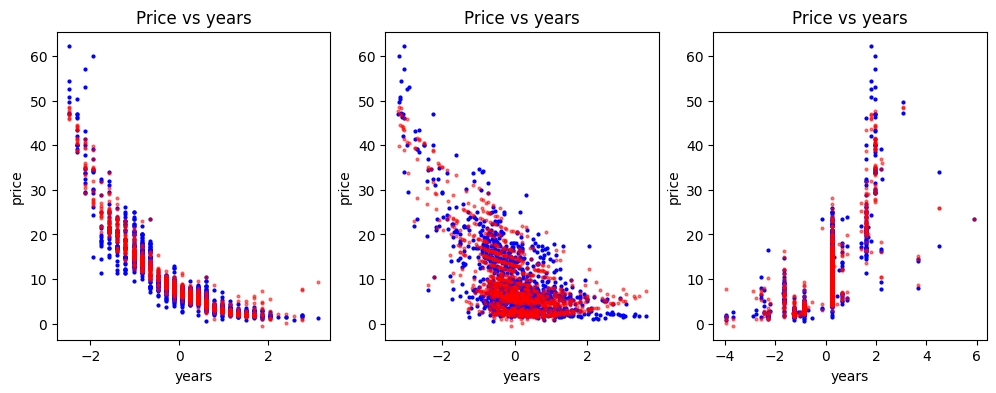

In [10]:
X_poly = transform_to_2nd_degree_matrix(X)
Y_pred = np.dot(X_poly, weights)


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], Y, color='blue', s=4)
plt.scatter(X[:,0], Y_pred, color='red', s=4, alpha=0.5)
plt.xlabel('years')
plt.ylabel('price')
plt.title('Price vs years')

plt.subplot(1, 3, 2)
plt.scatter(X[:,1], Y, color='blue', s=4)
plt.scatter(X[:,1], Y_pred, color='red', s=4, alpha=0.5)
plt.xlabel('years')
plt.ylabel('price')
plt.title('Price vs years')

plt.subplot(1, 3, 3)
plt.scatter(X[:,2], Y, color='blue', s=4)
plt.scatter(X[:,2], Y_pred, color='red', s=4, alpha=0.5)
plt.xlabel('years')
plt.ylabel('price')
plt.title('Price vs years')

plt.show()